In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.api import stats
from statsmodels.stats.anova import anova_lm


Import raw data from local drive. 

In [228]:
file_name = "Experimental_Structure_Data_05032025.xlsx"

fish = pd.read_excel(file_name, sheet_name='Fish')
relief = pd.read_excel(file_name, sheet_name='Relief')
species_codes = pd.read_excel(file_name, sheet_name='Species_Codes')

## Prepare Data

Calculate mean relief of each transect. Calculate standardized metrics for relief and substrate for each transect, and categorize transects as "High" or "Low" relief based on whether the mean relief values fall above or below 1.5, respectively. 

In [229]:
mean_relief= relief.groupby('Transect_Number')['Relief'].mean().reset_index(name='Mean_Relief')

mean_relief['Relief_Category'] = mean_relief['Mean_Relief'].apply(
    lambda x: 'High' if x >= 1.5 else 'Low'
)

Clean and prepare fish data. Calculate weighted size using size class data and pivot fish variables into workable format. 

In [230]:
fish_master = fish.merge(species_codes, on='Species', how='right')
fish_master = fish_master.merge(mean_relief, on = 'Transect_Number', how = 'right')

metadata = ['Date', 'Location', 'Recorder', 
                    'Buddy', 'Heading', 'Depth_ft', 'Unnamed: 13']

fish_master = fish_master.drop(columns=metadata)
fish_master

,Transect_Number,Treatment,Treatment_Time,Position,Species,Size_cm,Count,Species.1,Common_Name,Mobility,Mean_Relief,Relief_Category
0,2,Post-Kelp,1_hour,Benthic,SSER,25.0,1,RVAC,Olive rockfish,Intermediate,2.2,High
1,2,Pre-Kelp,0_hours,Mid-Column,SMYS,15.0,6,SATR,Blue rockfish,Midcolumn,2.2,High
2,2,Pre-Kelp,0_hours,Mid-Column,SMYS,20.0,6,EJAC,Blue rockfish,Midcolumn,2.2,High
3,2,Post-Kelp,1_hour,Mid-Column,SMYS,5.0,1,SMEL,Blue rockfish,Midcolumn,2.2,High
4,2,Post-Kelp,1_hour,Mid-Column,SMYS,15.0,4,NaN,Blue rockfish,Midcolumn,2.2,High
...,...,...,...,...,...,...,...,...,...,...,...,...
166,11,Post-Kelp,1_hour,NaN,HDEC,30.0,1,NaN,Kelp greenling,Benthic,1.5,High
167,11,Pre-Kelp,0_hours,NaN,OPIC,15.0,1,NaN,Painted greenling,Benthic,1.5,High
168,11,Post-Kelp,1_hour,NaN,OPIC,5.0,1,NaN,Painted greenling,Benthic,1.5,High
169,11,Pre-Kelp,0_hours,NaN,ELAT,15.0,11,NaN,Striped surfperch,Intermediate,1.5,High


Calculate total abundance, density, richness, biodiversity, and weighted size by transect and relief cateogry. 

In [231]:
# Compute Weighted Size
fish_master['Weighted_Size_cm'] = fish_master['Size_cm'] * fish_master['Count']

# Group once and compute multiple aggregations
aggregated = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Relief_Category']).agg(
    total_abundance=('Count', 'sum'),
    total_density=('Count', lambda x: x.sum() / 20),
    total_weighted_size=('Weighted_Size_cm', 'sum'),
    total_richness=('Species', 'nunique')
).reset_index()

# Define Shannon Index function
def shannon_diversity(group):
    species_counts = group['Count']
    proportions = species_counts / species_counts.sum()
    return -(proportions * np.log(proportions)).sum()

# Apply Shannon Index separately
shannon = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Relief_Category']).apply(
    shannon_diversity
).reset_index(name='total_biodiversity')

# Merge Shannon back into the main stats
fish_stats = aggregated.merge(shannon, on=['Transect_Number', 'Treatment_Time', 'Relief_Category'], how='left')

# Display result
fish_stats


C:\Users\FELAB\AppData\Local\Temp\ipykernel_7552\1165560515.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shannon = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Relief_Category']).apply(


,Transect_Number,Treatment_Time,Relief_Category,total_abundance,total_density,total_weighted_size,total_richness,total_biodiversity
0,2,0_hours,High,23,1.15,285.0,2,1.199539
1,2,1_hour,High,18,0.90,340.0,3,1.475008
2,2,1_week,High,14,0.70,105.0,2,0.758937
3,3,0_hours,High,54,2.70,610.0,2,1.185587
4,3,1_hour,High,38,1.90,590.0,1,1.495703
5,3,1_week,High,26,1.30,365.0,4,1.053072
6,4,0_hours,High,37,1.85,300.0,3,1.099869
7,4,1_hour,High,8,0.40,90.0,1,0.562335
8,4,1_week,High,30,1.50,355.0,5,0.951109
9,5,0_hours,Low,10,0.50,105.0,2,0.325083


## Fish Metrics by Treatment Time

### Summarize density, biodiversity, and size 

In [232]:
def compute_statistics(df, column_name, metric_prefix):
    stats = df.groupby(['Treatment_Time', 'Relief_Category'])[column_name].agg(
        mean_value='mean',
        std_value='std',
        count_value='size'
    ).reset_index()

    stats.rename(columns={
        'mean_value': f'mean_{metric_prefix}',
        'std_value': f'std_{metric_prefix}',
        'count_value': f'count_{metric_prefix}'
    }, inplace=True)

    stats[f'std_error_{metric_prefix}'] = stats[f'std_{metric_prefix}'] / np.sqrt(stats[f'count_{metric_prefix}'])

    return stats

density_stats       = compute_statistics(fish_stats, 'total_density', 'density')
biodiversity_stats  = compute_statistics(fish_stats, 'total_biodiversity', 'biodiversity')
size_stats          = compute_statistics(fish_stats, 'total_weighted_size', 'size')
richness_stats      = compute_statistics(fish_stats, 'total_richness', 'richness')

### Run the statistics

In [233]:
metrics_to_melt = ['total_density', 'total_richness', 
                   'total_biodiversity', 'total_weighted_size'] 

melted_df = pd.melt(fish_stats, id_vars=['Transect_Number', 'Treatment_Time', 'Relief_Category'], 
                    value_vars=metrics_to_melt, 
                    var_name='Metric', value_name='Value')

In [234]:
def run_two_way_anova(stats, metric_column):
    # Run the two-way ANOVA with interaction between Treatment Time and Relief Category
    model = ols(f'Value ~ C(Treatment_Time) * C(Relief_Category)', data=stats[stats['Metric'] == metric_column]).fit()
    anova_table = anova_lm(model, typ=2)  # Type II Sum of Squares
    print(f"\nANOVA Results for {metric_column}:")
    print(anova_table)
    return anova_table

def run_tukey_hsd(stats, metric_column):
    data = stats[stats['Metric'] == metric_column].copy()
    data['Group'] = data['Treatment_Time'].astype(str) + '_' + data['Relief_Category'].astype(str)
    
    tukey = pairwise_tukeyhsd(data['Value'], data['Group'], alpha=0.05)
    print(f"\nTukey's HSD Results for {metric_column}:")
    print(tukey.summary())
    return tukey


# Run Two-Way ANOVA and Tukey's HSD for each metric
for metric in metrics_to_melt:
    print(f"\n### Analyzing {metric} ###")
    run_two_way_anova(melted_df, metric)
    run_tukey_hsd(melted_df, metric)



### Analyzing total_density ###

ANOVA Results for total_density:
                                        sum_sq    df         F    PR(>F)
C(Treatment_Time)                     0.130150   2.0  0.137402  0.872397
C(Relief_Category)                    3.057449   1.0  6.455610  0.019021
C(Treatment_Time):C(Relief_Category)  1.303789   2.0  1.376435  0.274337
Residual                              9.945833  21.0       NaN       NaN

Tukey's HSD Results for total_density:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------------
0_hours_High 0_hours_Low  -0.9792 0.2771 -2.3689 0.4106  False
0_hours_High 1_hour_High   0.1083 0.9998 -1.1347 1.3514  False
0_hours_High  1_hour_Low  -0.8167 0.4643 -2.2064 0.5731  False
0_hours_High 1_week_High  -0.2792 0.9875 -1.6689 1.1106  False
0_hours_High  1_week_Low  -0.2167 0.9975 -1.7391 1.3057  False
 0_hours_Low 1_hour_High

### Plot the data

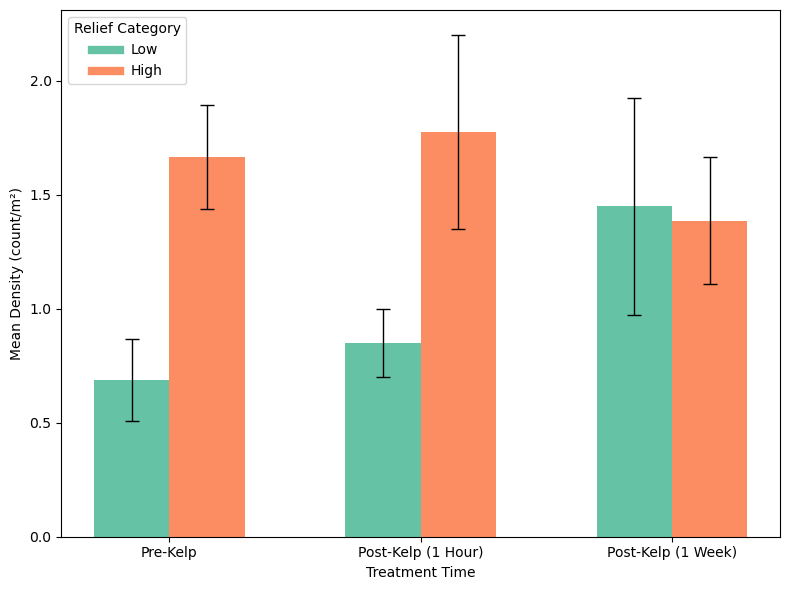

Figure saved as density_reliefxtreament_plot.jpg


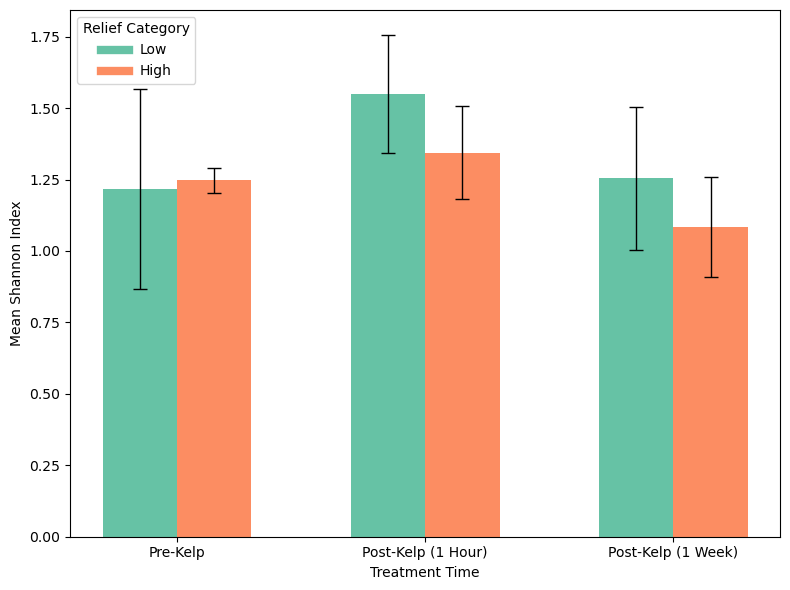

Figure saved as biodiversity_reliefxtreament_plot.jpg


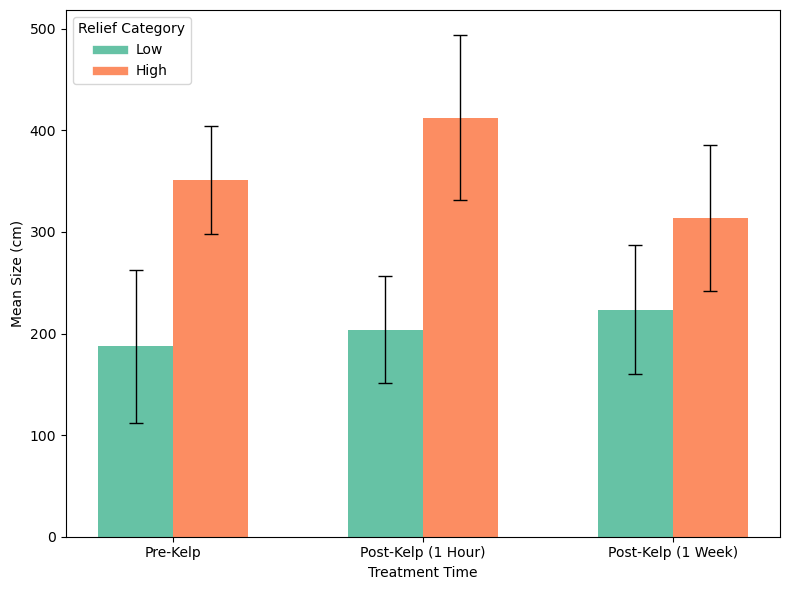

Figure saved as size_reliefxtreament_plot.jpg


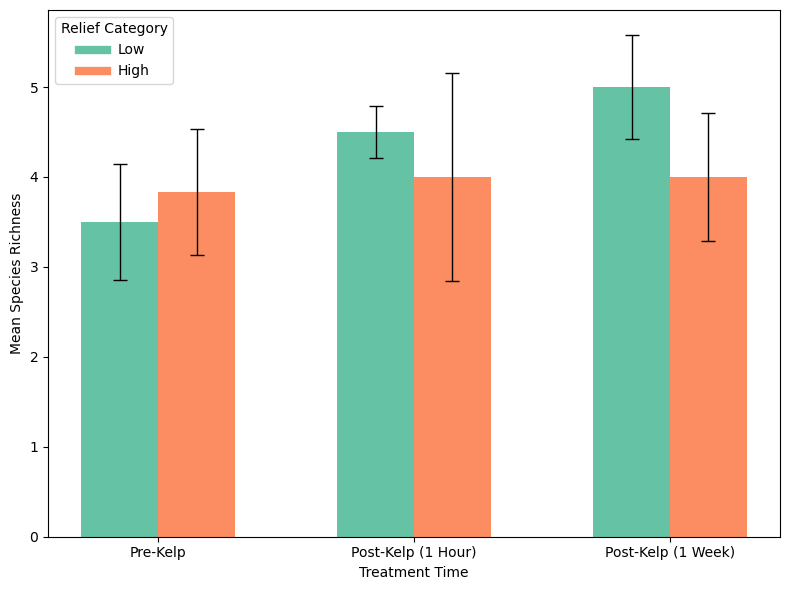

Figure saved as richness_reliefxtreament_plot.jpg


In [235]:
def plot_statistics_with_simple_error_bars(stats, y_column, y_label, metric_name):

    # Set up the figure
    plt.figure(figsize=(8, 6))

    # Custom x-axis label mapping
    label_map = {'0_hours': 'Pre-Kelp', '1_hour': 'Post-Kelp (1 Hour)', '1_week': 'Post-Kelp (1 Week)'}
    stats = stats.copy()
    stats['Treatment_Label'] = stats['Treatment_Time'].map(label_map)

    # Define positions on the x-axis
    treatment_times = stats['Treatment_Time'].unique()
    treatment_labels = [label_map[t] for t in treatment_times]
    relief_categories = sorted(stats['Relief_Category'].unique(), reverse=True)

    width = 0.3  # Width of each bar
    colors = sns.color_palette("Set2", len(relief_categories))

    legend_labels = []

    for i, treatment_time in enumerate(treatment_times):
        for j, relief_category in enumerate(relief_categories):
            row = stats[(stats['Treatment_Time'] == treatment_time) & 
                        (stats['Relief_Category'] == relief_category)].iloc[0]
            
            bar_x = i + j * width
            mean_value = row[y_column]
            std_error = row[f'std_error_{metric_name}']

            plt.bar(bar_x, mean_value, width=width, color=colors[j])
            plt.errorbar(bar_x, mean_value, yerr=std_error, fmt='none', 
                         color='black', capsize=5, elinewidth=1)

            if i == 0:
                legend_labels.append(relief_category)

    # Set custom x-tick positions and labels
    tick_positions = np.arange(len(treatment_times)) + (width / 2)
    plt.xticks(tick_positions, treatment_labels)

    plt.xlabel('Treatment Time')
    plt.ylabel(y_label)

    legend_handles = [Line2D([0], [0], color=colors[j], lw=6) for j in range(len(relief_categories))]
    plt.legend(legend_handles, legend_labels, title='Relief Category', loc='upper left')

    plt.tight_layout()

    # Save the figure as a jpg file
    filename = f'{metric_name}_reliefxtreament_plot.jpg'  # Name the file based on the metric name
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')  # Save as .jpg with high resolution

    # Optionally, display the plot
    plt.show()

    print(f"Figure saved as {filename}")
    
# Example usage:
plot_statistics_with_simple_error_bars(density_stats, 'mean_density', 'Mean Density (count/m²)', 'density')
plot_statistics_with_simple_error_bars(biodiversity_stats, 'mean_biodiversity', 'Mean Shannon Index', 'biodiversity')
plot_statistics_with_simple_error_bars(size_stats, 'mean_size', 'Mean Size (cm)', 'size')
plot_statistics_with_simple_error_bars(richness_stats, 'mean_richness', 'Mean Species Richness', 'richness')


In [236]:
# Example usage for Mobility, Relief, and Treatment
plot_metric_by_factor_bar(fish_stats, 'total_abundance', 'Mobility', 'Total Abundance', 'Total Abundance by Mobility')
plot_metric_by_factor_bar(fish_stats, 'total_abundance', 'Relief_Category', 'Total Abundance', 'Total Abundance by Relief')
plot_metric_by_factor_bar(fish_stats, 'total_abundance', 'Treatment_Time', 'Total Abundance', 'Total Abundance by Treatment Time')


KeyError: 'Metric'